# Data visualization and budget set up

In [3]:
# pip install prophet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 59.9 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.4/94.4 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 65.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
# pip install pathos

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 1.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 7.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


Import packages

In [1]:
import sys
sys.path.append(str('/home/jupyter/SearchForecasting/'))

from configparser import ConfigParser

from repo.MyConfigParser import MyConfigParser

from repo.LoadData import DataLoader
from repo.BuildModel import GenerateModelFile, CreateModel
from repo.Accuracy import AccuracyCalculator, ProphetParameterSearch, PlotAccuracyCharts
from repo.FileGenerator import *

import matplotlib.pyplot as plt


In [2]:
pd.set_option('display.float_format', '{:.6f}'.format)

initial config file to config_dict

In [3]:
updated_config = ConfigParser()
config_in_path = "/home/jupyter/SearchForecasting/Spain/June 2024 Update/config ups spain.ini"
updated_config.read(config_in_path)

getdict = MyConfigParser()
config_dict=getdict.GetDict(updated_config)
region = config_dict['CLIENTINFO']['country']
cutoff_month = config_dict['PROPHETSETTING']['cut_off_point']
base_start = config_dict['PROPHETSETTING']['reference_start_date1']
base_end = config_dict['PROPHETSETTING']['reference_end_date1']
periods = config_dict['PROPHETSETTING']['periods']
base_periods  = config_dict['PROPHETSETTING']['base_periods']

training_query = config_dict["PROPHETSETTING"]["training_query"]
_input = config_dict["PROPHETSETTING"]["input"]
_output = config_dict["PROPHETSETTING"]["output"]

output_bucket = config_dict["FILEPATH"]["output_bucket"]
folder_name = config_dict["FILEPATH"]["folder_name"]


today = datetime.date.today().strftime("%m.%d.%Y") #'03.10.2023' #
print(today)
base_path = config_dict["FILEPATH"]["base_path"]

boundary_df_in_path = base_path + config_dict["FILEPATH"]["boundary_df_in_path"]
daily_df_out_path = base_path + config_dict["FILEPATH"]["daily_df_out_path"]
analytical_file_path = base_path + config_dict["FILEPATH"]["analytical_file_path"]
cuts_df_in_path = base_path + config_dict["FILEPATH"]["cuts_df_in_path"]
plot_name = base_path + config_dict["FILEPATH"]["plot_name"]
constraint_file_name = base_path + config_dict["FILEPATH"]["constraint_file_name"]

05.23.2024


Query daily data

In [4]:
daily_df = GetBQData(training_query, _input, _output)
daily_df['day'] = daily_df.ds.dt.day
daily_df['month'] = daily_df.ds.dt.month
daily_df['year'] = daily_df.ds.dt.year

daily_df

/home/jupyter/SearchForecasting/repo/QueryingData.py:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  search_df.fillna(method = 'ffill', inplace = True)


,region,market,funnel,account_type,ds,X,y,day,month,year
0,Europe,Spain,-,Desktop,2022-01-01,1321.320000,11.000000,1,1,2022
1,Europe,Spain,-,Desktop,2022-01-02,2564.670000,33.000000,2,1,2022
2,Europe,Spain,-,Desktop,2022-01-03,25055.280000,402.000000,3,1,2022
3,Europe,Spain,-,Desktop,2022-01-04,26718.220000,332.000000,4,1,2022
4,Europe,Spain,-,Desktop,2022-01-05,26038.940000,177.000000,5,1,2022
...,...,...,...,...,...,...,...,...,...,...
1615,Europe,Spain,-,Mobile & Tablet,2024-04-25,327.300000,5.000000,25,4,2024
1616,Europe,Spain,-,Mobile & Tablet,2024-04-26,327.300000,9.000000,26,4,2024
1617,Europe,Spain,-,Mobile & Tablet,2024-04-28,327.300000,5.000000,28,4,2024
1618,Europe,Spain,-,Mobile & Tablet,2024-04-29,327.300000,15.000000,29,4,2024


In [6]:
daily_df.ds.max()

Timestamp('2024-04-30 00:00:00')

In [7]:
# pre_optimization_budget = daily_df[['year','X']].loc[(daily_df.month == 4) & 
#                                                      (daily_df.year >= 2020) & (daily_df.day >= 25)].groupby(['year']).sum().mean()


year_2022 = daily_df.loc[(daily_df['ds'] >= '2022-04-28') & (daily_df['ds'] <= '2022-06-04'), 'X'].sum()
year_2023 = daily_df.loc[(daily_df['ds'] >= '2023-04-27') & (daily_df['ds'] <= '2023-06-03'), 'X'].sum()
pre_optimization_budget = (year_2022 + year_2023) / 2

pre_optimization_budget

779407.8

In [8]:
df = daily_df.copy()
df.market = region
df = df.groupby(['region', 'market', 'account_type', 'funnel', 'ds']).sum().reset_index()

In [9]:
# remove rows without date or conversion quantity
df = df[~df[['ds', 'y']].isin([np.nan, np.inf, -np.inf]).any(axis=1)]

In [58]:
# df.loc[(df['ds'] >= '2021-08-01')&(df['ds'] <= '2021-10-31') & ((df.account_type == 'Bing Ads') & (df.funnel == 'Brand'))].groupby(['month']).sum(numeric_only=True)
# df.loc[((df['ds'] >= '2019-03-01') & (df['ds'] <= '2019-08-31')) & ((df.account_type == 'Bing Ads') & (df.funnel == 'Brand'))].groupby(['month']).sum(numeric_only=True)

,X,y,day,year
month,,,,
8,18519.989924,5825.000000,496,62651
9,17691.090096,6968.000000,465,60630
10,17366.269994,6341.000000,496,62651


In [10]:
df = df[~df[['ds', 'y']].isin([np.nan, np.inf, -np.inf]).any(axis=1)]
#df = df[df.ds < cutoff_month]
# remove inactive days
df.drop(df[((df['ds'] >= '2021-08-01')&(df['ds'] <= '2021-10-31')) & ((df.account_type == 'Bing Ads') & (df.funnel == 'Brand'))].index,
       axis = 0, inplace = True)
df.drop(df[((df['ds'] >= '2019-03-01')&(df['ds'] <= '2019-08-31')) & ((df.account_type == 'Bing Ads') & (df.funnel == 'Brand'))].index,
       axis = 0, inplace = True)

df.drop(df[((df['ds'] >= '2021-07-01')&(df['ds'] <= '2021-12-31')) & ((df.account_type == 'Bing Ads') & (df.funnel == 'Generic'))].index,
       axis = 0, inplace = True)

In [11]:
df['year_month'] = df['ds'].dt.to_period('M')

BingAds_Generic = df.loc[((df.account_type == 'Bing Ads') & (df.funnel == 'Generic'))].groupby(['year_month'])[['year_month','X','y']].sum(numeric_only=True).reset_index()

In [12]:
BingAds_Generic

,year_month,X,y


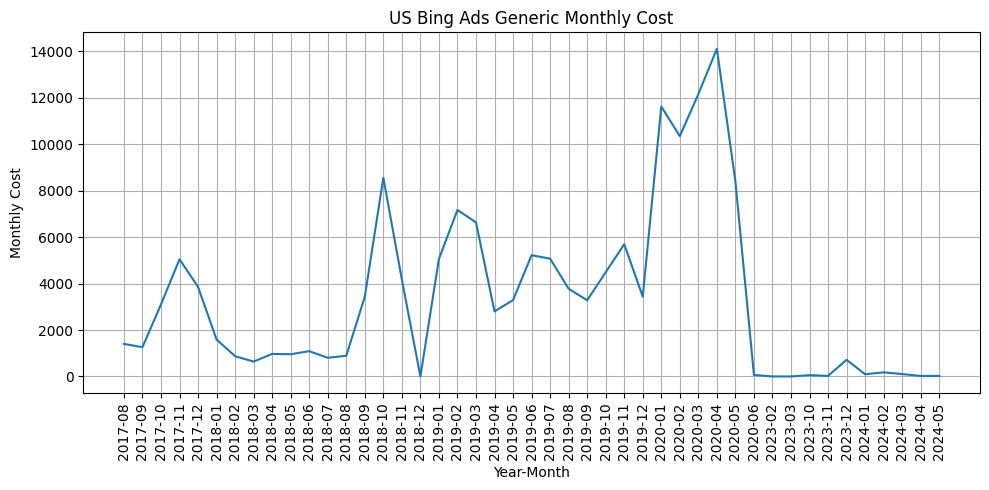

In [48]:
# Plotting the time series graph
plt.figure(figsize=(10, 5))
plt.plot(BingAds_Generic['year_month'].astype(str), BingAds_Generic['X'])  # Convert year_month to string for plotting
plt.title('US Bing Ads Generic Monthly Cost')
plt.xlabel('Year-Month')
plt.ylabel('Monthly Cost')
plt.grid(True)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout
plt.show()

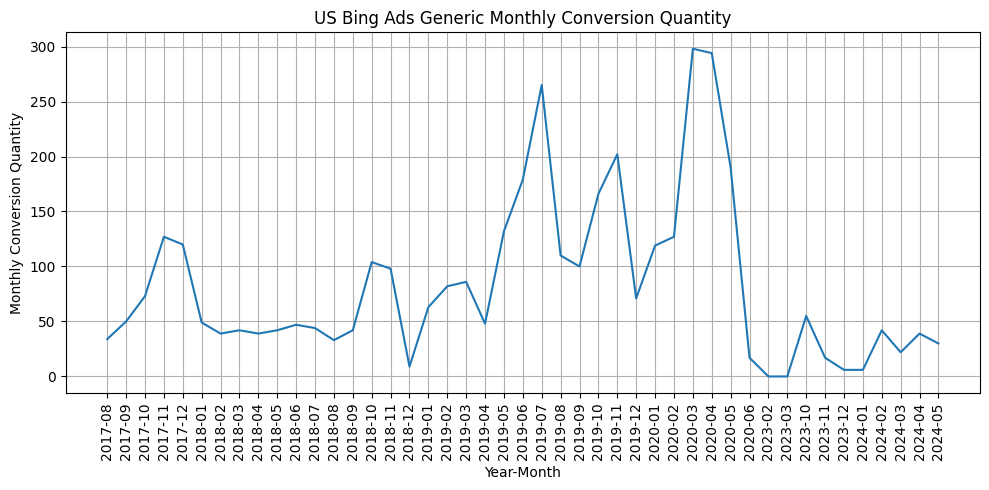

In [49]:
# Plotting the time series graph
plt.figure(figsize=(10, 5))
plt.plot(BingAds_Generic['year_month'].astype(str), BingAds_Generic['y'])  # Convert year_month to string for plotting
plt.title('US Bing Ads Generic Monthly Conversion Quantity')
plt.xlabel('Year-Month')
plt.ylabel('Monthly Conversion Quantity')
plt.grid(True)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout
plt.show()